In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, precision_recall_curve, average_precision_score, 
                             accuracy_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score, 
                                     train_test_split)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
data = pd.read_excel('/kaggle/input/data-credit/data1.xlsx')
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT
0,2023-04-03,2023-04-04,2023-04-04,2
1,2023-04-03,2023-04-04,2023-04-10,1
2,2023-04-03,2023-04-05,2023-04-07,1
3,2023-04-03,2023-04-06,2023-04-06,1
4,2023-04-03,2023-04-11,2023-04-15,1
...,...,...,...,...
3312,2023-06-14,2023-06-15,NaT,107
3313,2023-06-14,NaT,NaT,319
3314,2023-06-15,2023-06-15,2023-06-15,11
3315,2023-06-15,2023-06-15,NaT,37


In [3]:
def create_features(data):
    #target column 
    # Create the 'Utilized' column
    data['Utilized'] = data['UTILIZATION_DATE'].notna().astype(int)

    # Calculate date differences
    data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days
    data['DIFFERENCE_AU'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days
   
    # Binary features based on date comparisons
    data['Same_Day_Agreement_Utilization'] = (data['AGREEMENT_DATE'] == data['UTILIZATION_DATE']).astype(int)
    data['Same_Day_Application_Agreement'] = (data['APPLICATION_DATE'] == data['AGREEMENT_DATE']).astype(int)
    data['Missing_Agreement_Date'] = data['AGREEMENT_DATE'].isna().astype(int)

    # Categorical features based on dates
    data['application_day_of_week'] = data['APPLICATION_DATE'].dt.dayofweek
    data['application_month'] = data['APPLICATION_DATE'].dt.month
    data['agreement_day_of_week'] = data['AGREEMENT_DATE'].dt.dayofweek
    data.drop(columns = ['APPLICATION_DATE', 'AGREEMENT_DATE', 'UTILIZATION_DATE', 'CNT'], inplace = True)

    return data

In [4]:
data = create_features(data)
data.columns

Index(['Utilized', 'DIFFERENCE_AA', 'DIFFERENCE_AU',
       'Same_Day_Agreement_Utilization', 'Same_Day_Application_Agreement',
       'Missing_Agreement_Date', 'application_day_of_week',
       'application_month', 'agreement_day_of_week'],
      dtype='object')

In [5]:
# the correlation matrix
corr_matrix = data.corr()

# interactive heatmap
fig = px.imshow(corr_matrix,
                color_continuous_scale='bluered',  # Use a supported colorscale
                text_auto=True,
                title='Correlation Heatmap')

fig.update_layout(
    xaxis_title='Features',
    yaxis_title='Features',
    title_font_size=24,
    xaxis_tickangle=-45,
    width=1000,  
    height=800   
)

fig.show()

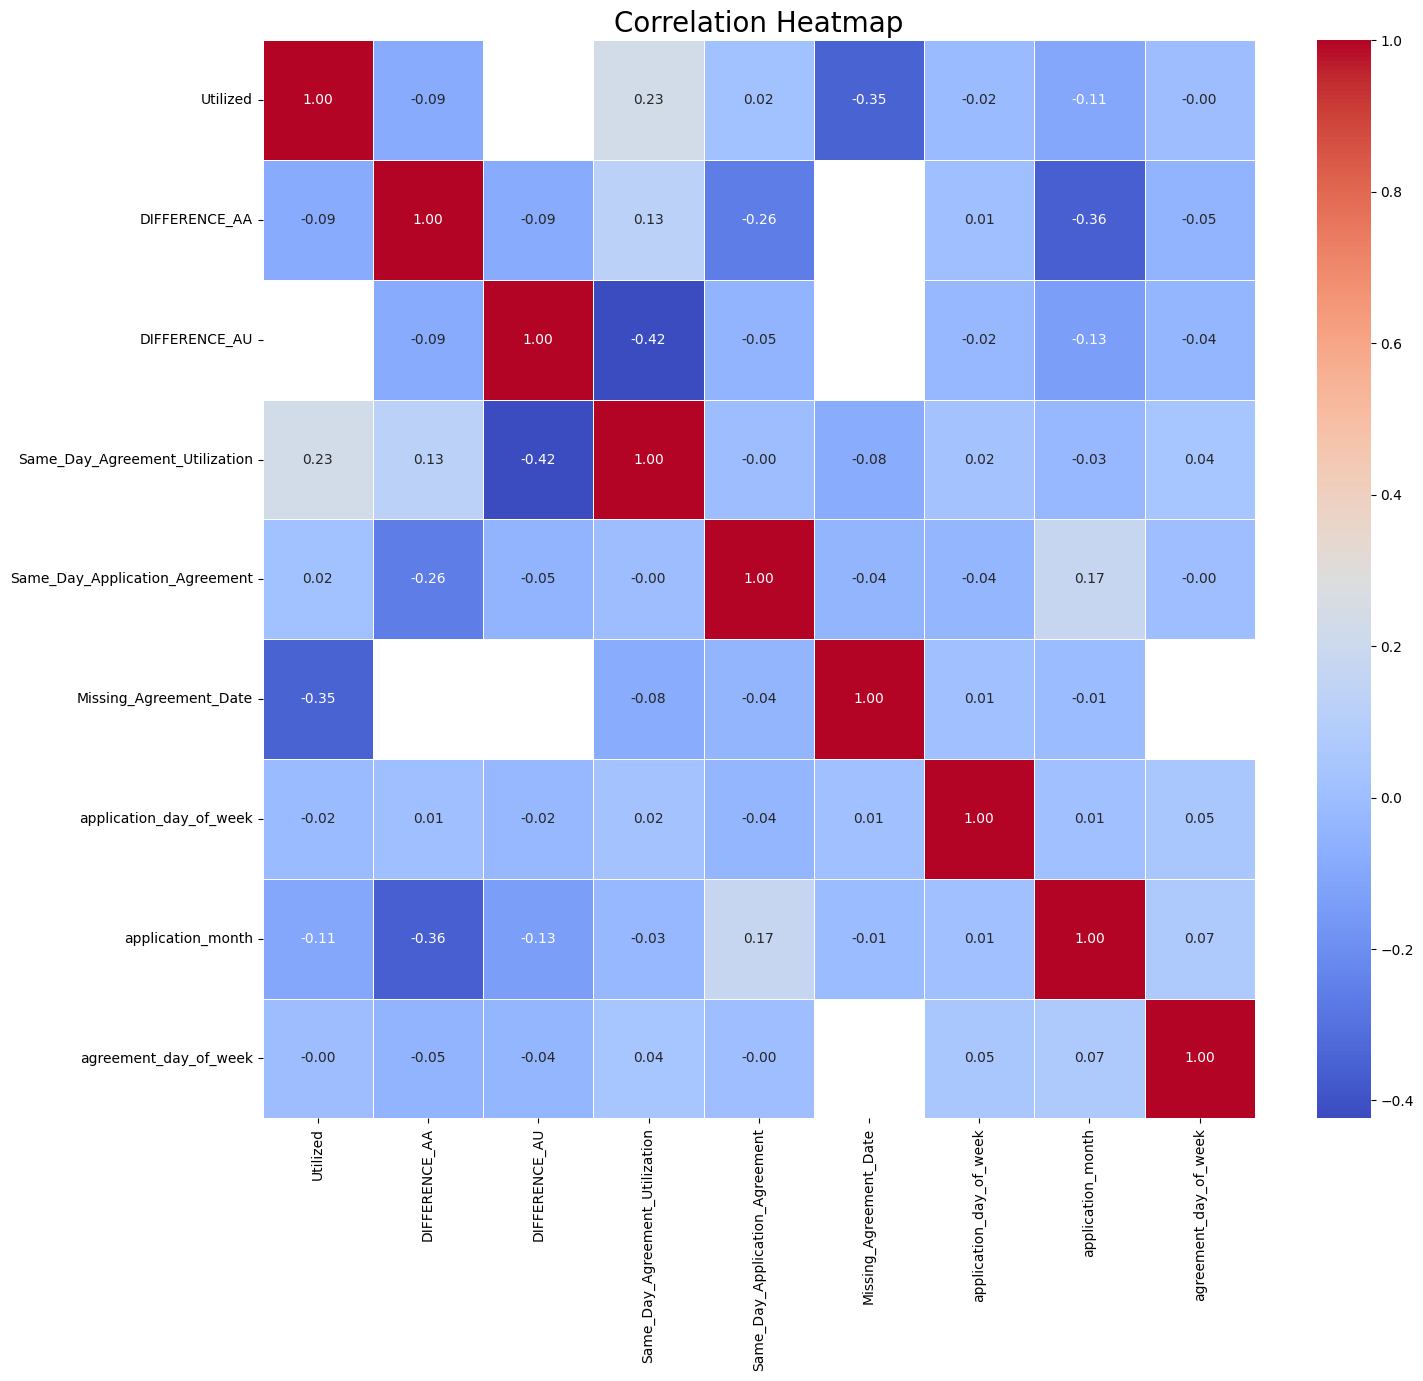

In [6]:
plt.figure(figsize=(16, 14))  # Set the size of the figure
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', size=20)
plt.show()

In [7]:
data.isnull().sum()

Utilized                            0
DIFFERENCE_AA                      74
DIFFERENCE_AU                     518
Same_Day_Agreement_Utilization      0
Same_Day_Application_Agreement      0
Missing_Agreement_Date              0
application_day_of_week             0
application_month                   0
agreement_day_of_week              74
dtype: int64

In [8]:
data.columns

Index(['Utilized', 'DIFFERENCE_AA', 'DIFFERENCE_AU',
       'Same_Day_Agreement_Utilization', 'Same_Day_Application_Agreement',
       'Missing_Agreement_Date', 'application_day_of_week',
       'application_month', 'agreement_day_of_week'],
      dtype='object')

In [9]:
data['Row_Index'] = [i for i in range(1, len(data) + 1)]
columns = ['Row_Index'] + [col for col in data.columns if col != 'Row_Index']
data = data[columns]

# features and target variable
X = data.drop(columns=['Utilized'])  # Features
y = data['Utilized']  # Target variable
# Extract the Row_Index for later identification
row_index = data['Row_Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2653, 9)
X_test shape: (664, 9)
y_train shape: (2653,)
y_test shape: (664,)


Training Set Distribution: [ 400 2253]
Training Set Proportions: [0.15077271 0.84922729]
Test Set Distribution: [118 546]
Test Set Proportions: [0.17771084 0.82228916]


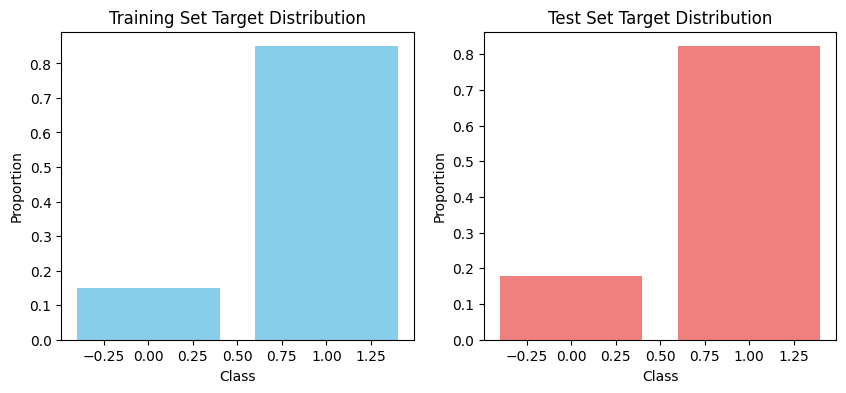

In [10]:
# Calculate the distribution of the target variable in the training set
y_train_distribution = np.bincount(y_train)
y_test_distribution = np.bincount(y_test)

# Calculate proportions
y_train_proportions = y_train_distribution / len(y_train)
y_test_proportions = y_test_distribution / len(y_test)

# Print the results
print("Training Set Distribution:", y_train_distribution)
print("Training Set Proportions:", y_train_proportions)
print("Test Set Distribution:", y_test_distribution)
print("Test Set Proportions:", y_test_proportions)

# Visualize the distribution in the training set
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(y_train_distribution)), y_train_proportions, color='skyblue')
plt.title('Training Set Target Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')

# Visualize the distribution in the test set
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(y_test_distribution)), y_test_proportions, color='lightcoral')
plt.title('Test Set Target Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

In [11]:
data.isnull().sum()

Row_Index                           0
Utilized                            0
DIFFERENCE_AA                      74
DIFFERENCE_AU                     518
Same_Day_Agreement_Utilization      0
Same_Day_Application_Agreement      0
Missing_Agreement_Date              0
application_day_of_week             0
application_month                   0
agreement_day_of_week              74
dtype: int64

In [12]:
# Impute missing values using the mean
# Compute mean for columns with missing values
median_values = data[['DIFFERENCE_AA','DIFFERENCE_AU','agreement_day_of_week']].median()
X_train.fillna(median_values , inplace=True)
X_test.fillna(median_values , inplace=True)

In [13]:
# Store Row_Index separately
row_index_train = None
row_index_test = None

if 'Row_Index' in X.columns:
    row_index_train = X_train['Row_Index']
    row_index_test = X_test['Row_Index']
    X = X.drop(columns=['Row_Index'])  # Remove Row_Index from the feature set

Index(['Row_Index', 'Utilized', 'DIFFERENCE_AA', 'DIFFERENCE_AU',
       'Same_Day_Agreement_Utilization', 'Same_Day_Application_Agreement',
       'Missing_Agreement_Date', 'application_day_of_week',
       'application_month', 'agreement_day_of_week'],
      dtype='object')
                          Feature  Importance
0                        Utilized    0.670626
2                   DIFFERENCE_AU    0.277784
5          Missing_Agreement_Date    0.025591
3  Same_Day_Agreement_Utilization    0.009815
1                   DIFFERENCE_AA    0.009315
7               application_month    0.003817
8           agreement_day_of_week    0.001884
6         application_day_of_week    0.001014
4  Same_Day_Application_Agreement    0.000153


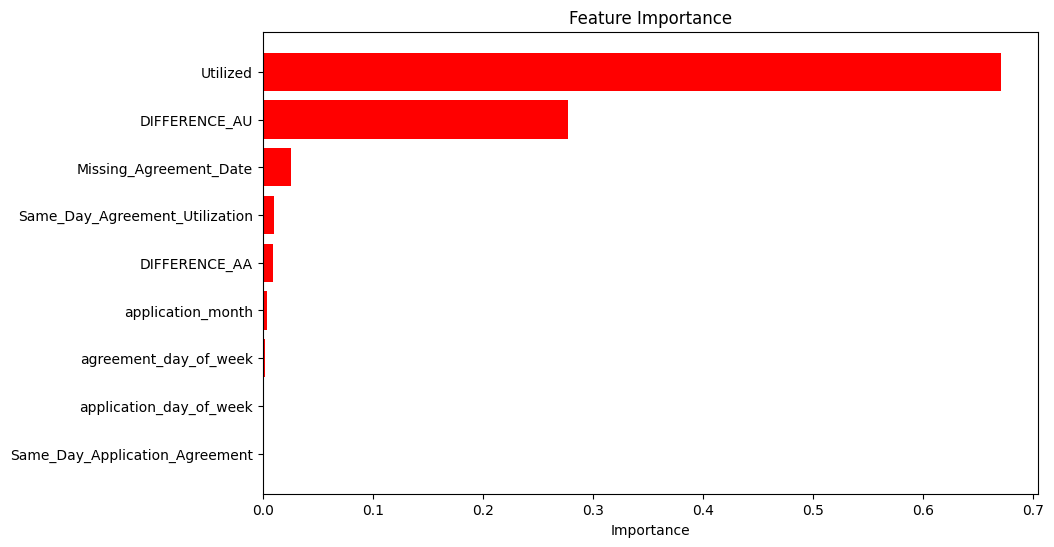

In [14]:
# Check the columns in your DataFrame
print(data.columns)

# Update the list of columns to drop, ensuring they exist
columns_to_drop = ['Row_Index']  # Update this list if needed

# Ensure no non-existent columns are being dropped
numerical_columns = data.drop(columns=columns_to_drop).columns

# Extract numerical data
X_numerical = data[numerical_columns]

# Impute missing values in numerical data
imputer = SimpleImputer(strategy='mean')  # Impute using the mean
X_imputed = imputer.fit_transform(X_numerical)

# Scale the features (only the numerical part)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train1, y_train1)

# Extract feature importance
importances = model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': numerical_columns,  # Use the numerical columns for feature names
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# Evaluation Functions

In [15]:
# Function to visualize the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

# Function to print and plot the Classification Report
def plot_classification_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# Function to plot the ROC Curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

# Function to plot Feature Importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center', color='red')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontsize=14)
    plt.title('Feature Importance', fontsize=16)
    plt.gca().invert_yaxis()
    plt.show()

# Function to plot Cross-Validation ROC AUC scores
def plot_cv_roc_auc_scores(cv_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(cv_scores, marker='o', linestyle='-', color='blue')
    plt.title('Cross-Validation ROC AUC Scores', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel('ROC AUC Score', fontsize=14)
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.show()

# Optional: Function to visualize GridSearchCV results
def plot_grid_search_results(grid_search):
    results = grid_search.cv_results_
    plt.figure(figsize=(8, 6))
    plt.plot(results['mean_test_score'], marker='o', linestyle='-', color='green')
    plt.title('Grid Search CV Results', fontsize=16)
    plt.xlabel('Hyperparameter combination index', fontsize=14)
    plt.ylabel('Mean ROC AUC Score', fontsize=14)
    plt.grid(True)
    plt.show()

# Baseline: Logistic Regression 

Confusion Matrix:
[[103  15]
 [161 385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.87      0.54       118
           1       0.96      0.71      0.81       546

    accuracy                           0.73       664
   macro avg       0.68      0.79      0.68       664
weighted avg       0.86      0.73      0.77       664


ROC AUC Score: 0.8694046066927422

Cross-validation ROC AUC scores: [0.84162971 0.83054324 0.85124723 0.87611111 0.85619444]
Mean CV ROC AUC score: 0.8511451465878295


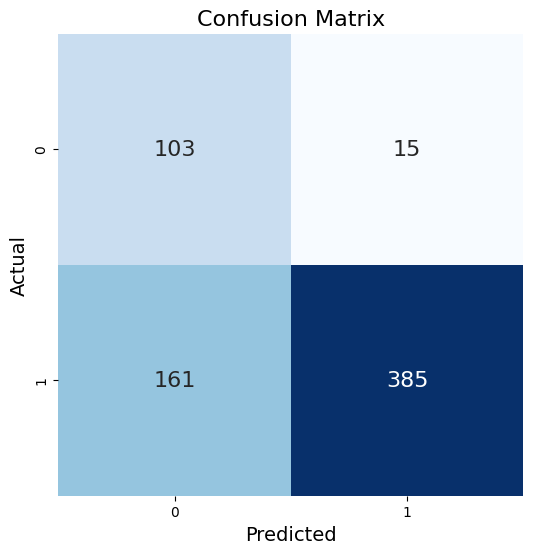

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.87      0.54       118
           1       0.96      0.71      0.81       546

    accuracy                           0.73       664
   macro avg       0.68      0.79      0.68       664
weighted avg       0.86      0.73      0.77       664



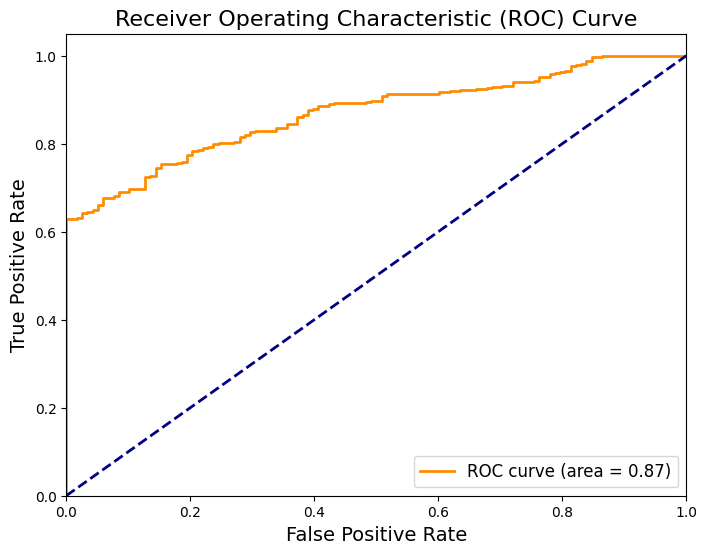

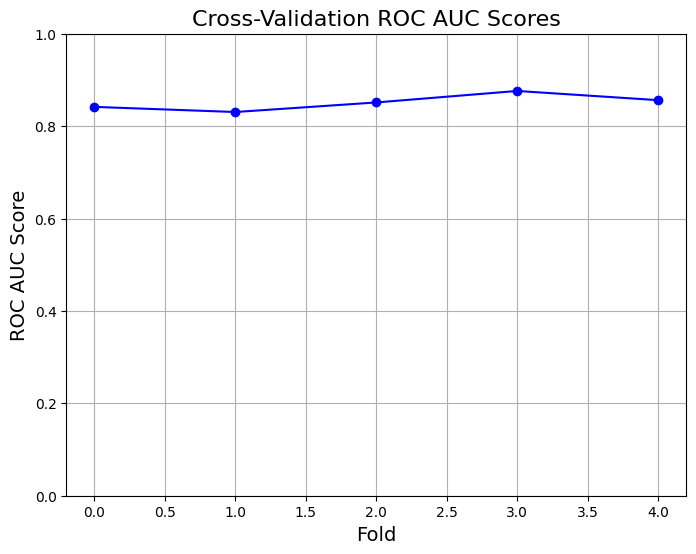

In [16]:
#the class weights for imbalanced classes
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Define the Logistic Regression Model
logistic_model = LogisticRegression(random_state=42, class_weight=class_weights_dict, max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate the Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
print(f"\nROC AUC Score: {roc_auc_logistic}")

cv_scores_logistic = cross_val_score(logistic_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores_logistic}")
print(f"Mean CV ROC AUC score: {cv_scores_logistic.mean()}")

# Visualize the results
plot_confusion_matrix(y_test, y_pred_logistic)
plot_classification_report(y_test, y_pred_logistic)
plot_roc_curve(y_test, y_prob_logistic)
plot_cv_roc_auc_scores(cv_scores_logistic)

# Random Forest Model 

In [17]:
# SImbalanced Classes using Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Removed 'auto' to avoid deprecation warning
}

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5)

#  Wrap the GridSearchCV fit process with tqdm progress bar
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
n_iterations = np.prod([len(param_grid[key]) for key in param_grid]) * cv.get_n_splits()

with tqdm(total=n_iterations, desc="GridSearchCV Progress", unit="iteration") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update()

#  Evaluation of the Model
best_model = grid_search.best_estimator_

# Prediction on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc}")

# Optional: Cross-validation score for the final model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC score: {cv_scores.mean()}")

GridSearchCV Progress:   0%|          | 1/1080 [02:46<50:01:55, 166.93s/iteration]


Confusion Matrix:
[[118   0]
 [ 79 467]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       118
           1       1.00      0.86      0.92       546

    accuracy                           0.88       664
   macro avg       0.80      0.93      0.84       664
weighted avg       0.93      0.88      0.89       664


ROC AUC Score: 0.9432312038244243

Cross-validation ROC AUC scores: [0.95206486 0.9535061  0.95433758 0.97320833 0.95775   ]
Mean CV ROC AUC score: 0.9581733739837398


In [18]:
y_pred 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

The model is significantly skewed towards predicting one class over the other. This is evident from the confusion matrix, where the model predicts the positive class (class 1) correctly for most cases but fails to identify the negative class (class 0) entirely.

Here's what the confusion matrix indicates:

True Positives (TP): 467 - The model correctly predicted 467 instances as the positive class (1).
True Negatives (TN): 118 - The model correctly predicted 118 instances as the negative class (0).
False Positives (FP): 0 - The model did not incorrectly predict any instances as positive that were actually negative.
False Negatives (FN): 79 - The model incorrectly predicted 79 instances as negative that were actually positive.


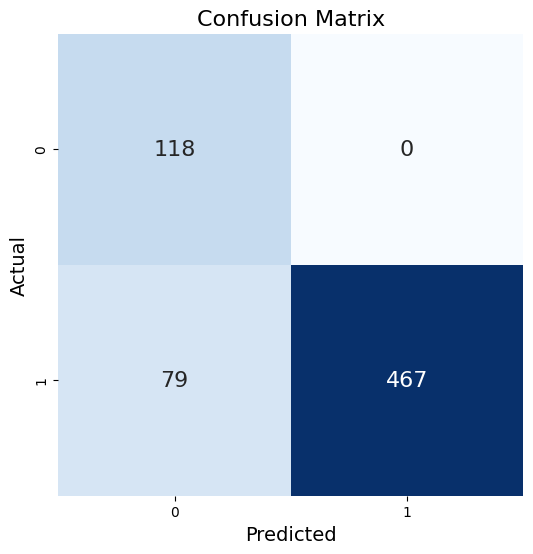

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       118
           1       1.00      0.86      0.92       546

    accuracy                           0.88       664
   macro avg       0.80      0.93      0.84       664
weighted avg       0.93      0.88      0.89       664



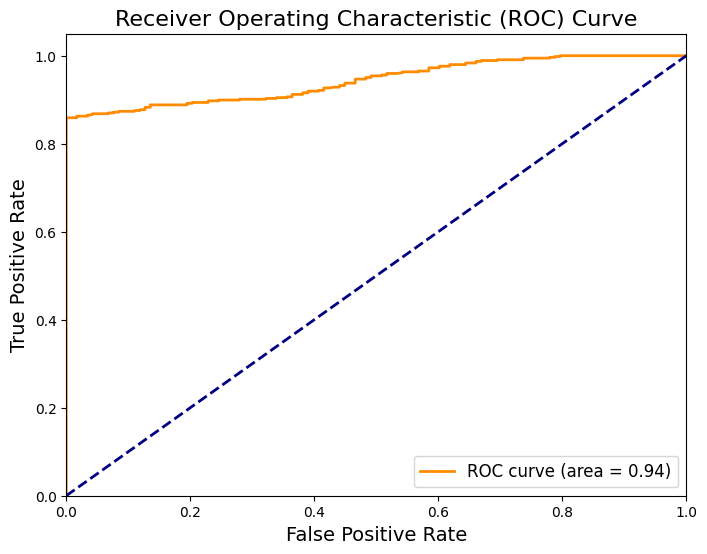

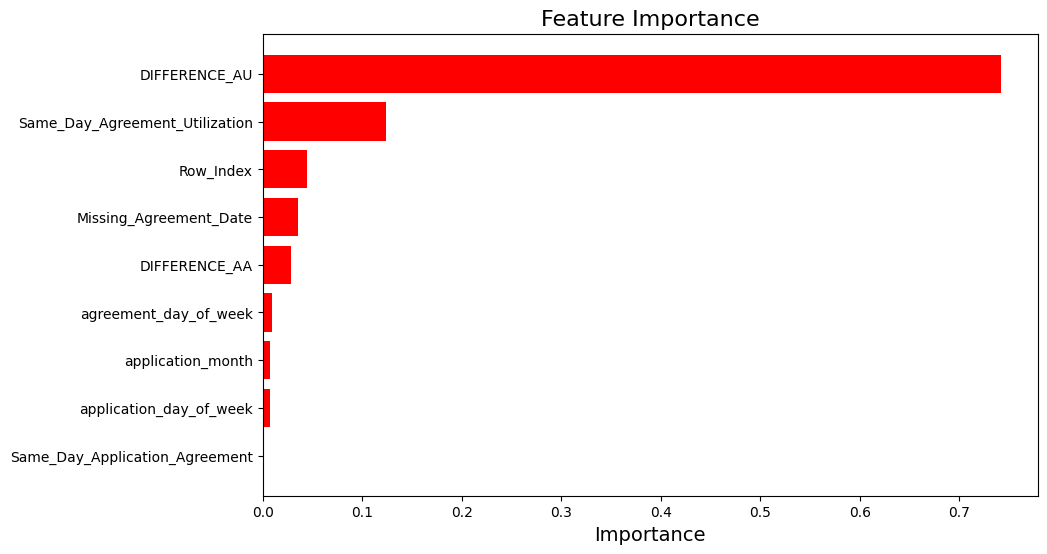

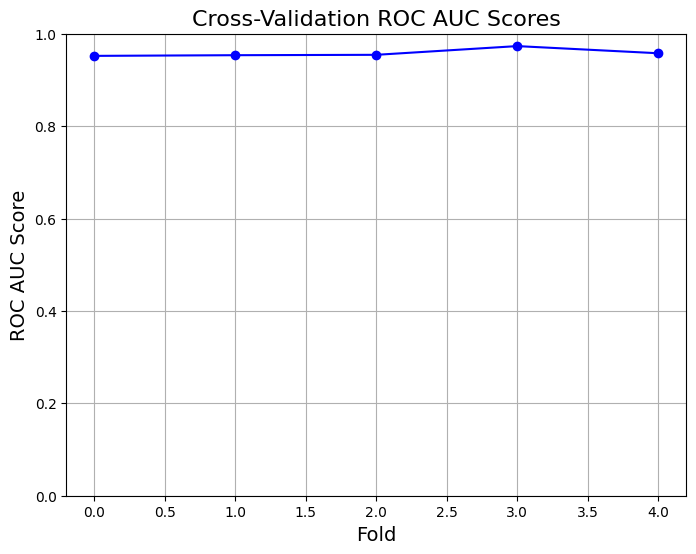

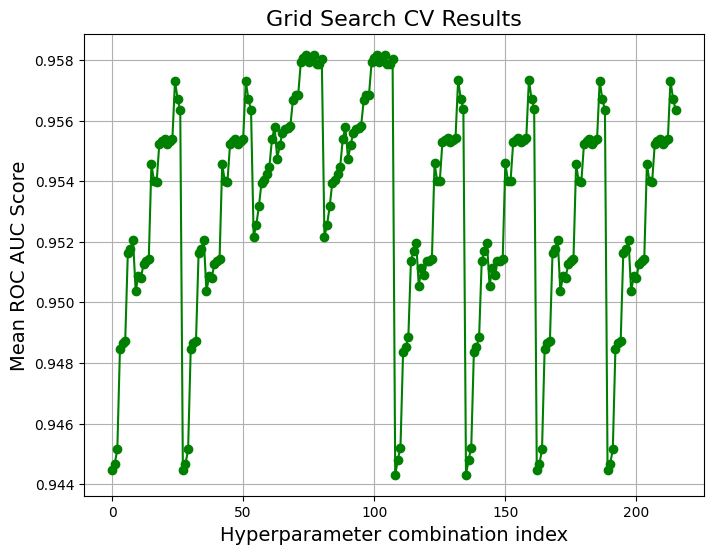

In [19]:
# Assuming X_train is a pandas DataFrame
feature_names = X_train.columns

# usage after model training and evaluation:
plot_confusion_matrix(y_test, y_pred)
plot_classification_report(y_test, y_pred)
plot_roc_curve(y_test, y_prob)
plot_feature_importance(best_model, feature_names)
plot_cv_roc_auc_scores(cv_scores)
plot_grid_search_results(grid_search)


#  prophet

GridSearchCV Progress:   0%|          | 1/1080 [02:43<48:55:41, 163.25s/iteration]


Confusion Matrix:
[[118   0]
 [ 79 467]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       118
           1       1.00      0.86      0.92       546

    accuracy                           0.88       664
   macro avg       0.80      0.93      0.84       664
weighted avg       0.93      0.88      0.89       664


ROC AUC Score: 0.9432312038244243


14:19:45 - cmdstanpy - INFO - Chain [1] start processing



Cross-validation ROC AUC scores: [0.95206486 0.9535061  0.95433758 0.97320833 0.95775   ]
Mean CV ROC AUC score: 0.9581733739837398


14:19:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



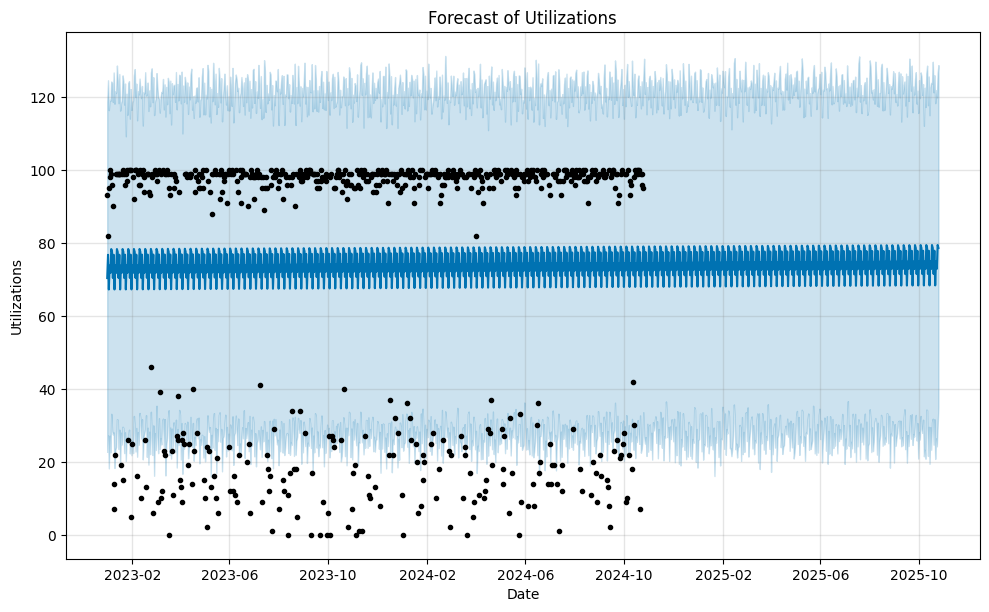

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



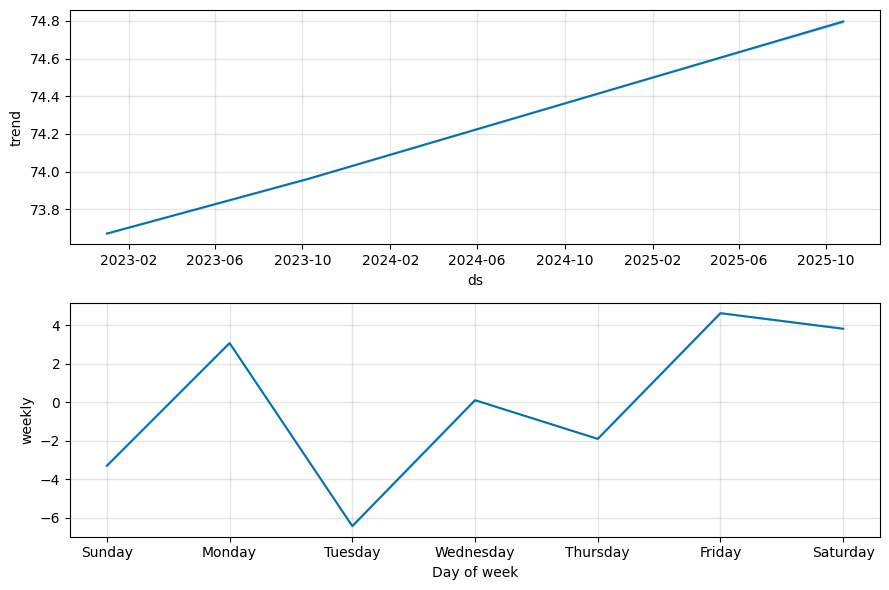

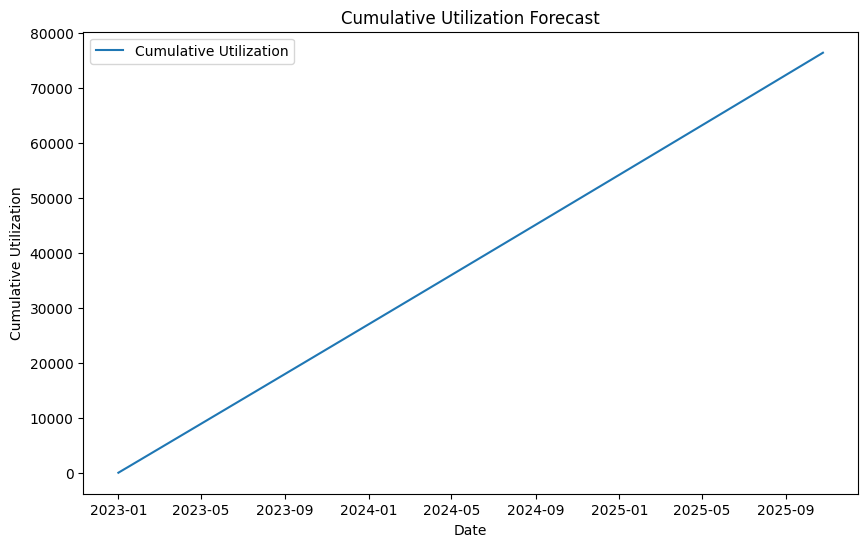

             ds       yhat  yhat_lower  yhat_upper
1024 2025-10-21  68.354219   20.785836  118.306763
1025 2025-10-22  74.902012   26.421307  121.876293
1026 2025-10-23  72.892484   24.234049  119.871365
1027 2025-10-24  79.429749   29.606141  126.621038
1028 2025-10-25  78.620855   35.037392  128.730077


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm import tqdm
import numpy as np

# Assuming you have your data split into X_train, X_test, y_train, y_test

# Step 1: Handle Imbalanced Classes using Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Define the model
model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5)

# Grid Search with Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
n_iterations = np.prod([len(param_grid[key]) for key in param_grid]) * cv.get_n_splits()

with tqdm(total=n_iterations, desc="GridSearchCV Progress", unit="iteration") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update()

# Get the best model
best_model = grid_search.best_estimator_

# Step 2: Evaluate the Model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc}")

# Optional: Cross-validation score for the final model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC score: {cv_scores.mean()}")

# Step 3: Prepare Forecasting with Prophet

# Use the model to get probabilities (as an example)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Create DataFrame for predictions
dates = pd.date_range(start='2023-01-01', periods=len(y_pred_proba), freq='D')
df_predictions = pd.DataFrame({
    'date': dates,
    'utilization_prob': y_pred_proba
})

# Optionally convert probabilities to counts if needed
df_predictions['utilization_count'] = (df_predictions['utilization_prob'] * 100).astype(int)  # Example scaling

# Aggregate daily predictions
df_predictions.set_index('date', inplace=True)
daily_utilizations = df_predictions['utilization_count'].resample('D').sum()

# Prepare data for Prophet
df_prophet = daily_utilizations.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet expects 'ds' for date and 'y' for value

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Create future DataFrame for forecasting
future = model_prophet.make_future_dataframe(periods=365)  # Forecast for the next year

# Predict future utilizations
forecast = model_prophet.predict(future)

# Plot forecast
fig = model_prophet.plot(forecast)
plt.title('Forecast of Utilizations')
plt.xlabel('Date')
plt.ylabel('Utilizations')
plt.show()

# Plot forecast components
fig2 = model_prophet.plot_components(forecast)
plt.show()

# Calculate and plot cumulative utilization
forecast['cumulative_y'] = forecast['yhat'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['cumulative_y'], label='Cumulative Utilization')
plt.xlabel('Date')
plt.ylabel('Cumulative Utilization')
plt.title('Cumulative Utilization Forecast')
plt.legend()
plt.show()

# Display some of the forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


ds (Date): The date for the forecasted values.
yhat (Forecasted Value): Predicted utilization values.
yhat_lower (Lower Bound): Lower bound of the forecast interval.
yhat_upper (Upper Bound): Upper bound of the forecast interval.


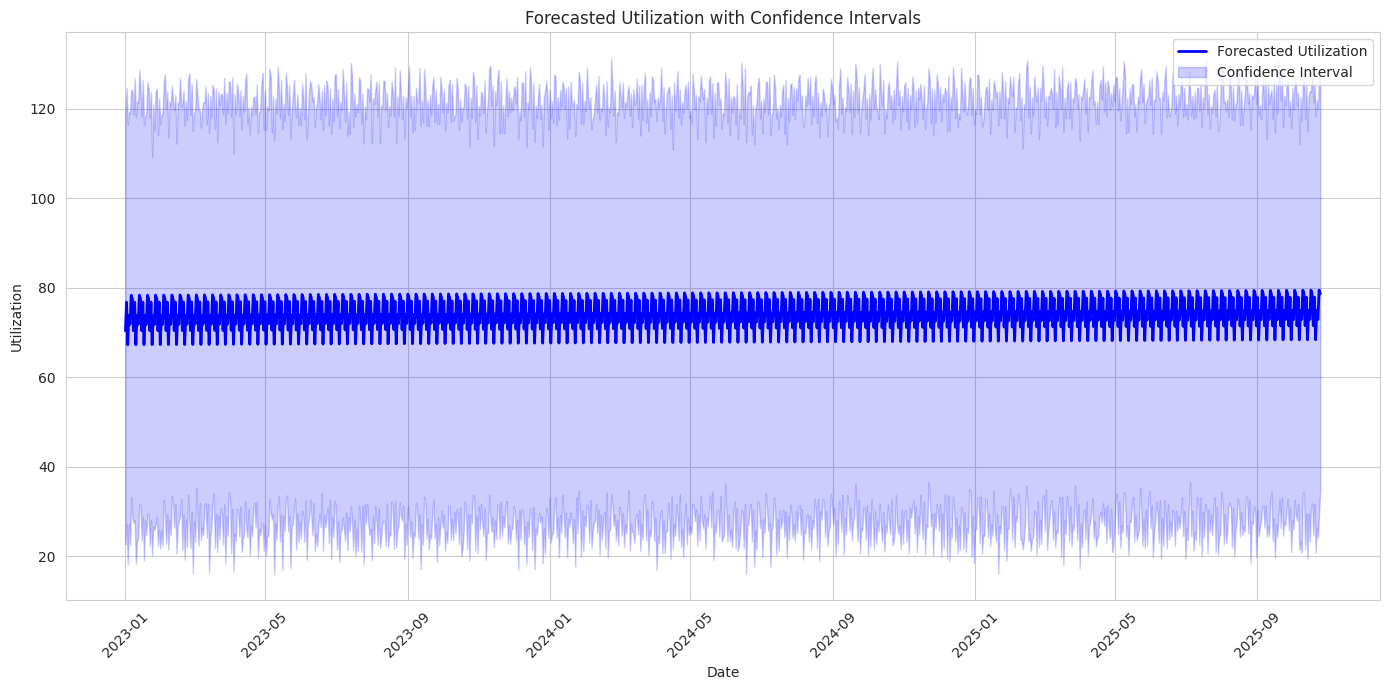

In [21]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the forecasted values
ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Utilization', color='blue', linewidth=2)

# Plot the confidence intervals
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Utilization')
ax.set_title('Forecasted Utilization with Confidence Intervals')
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


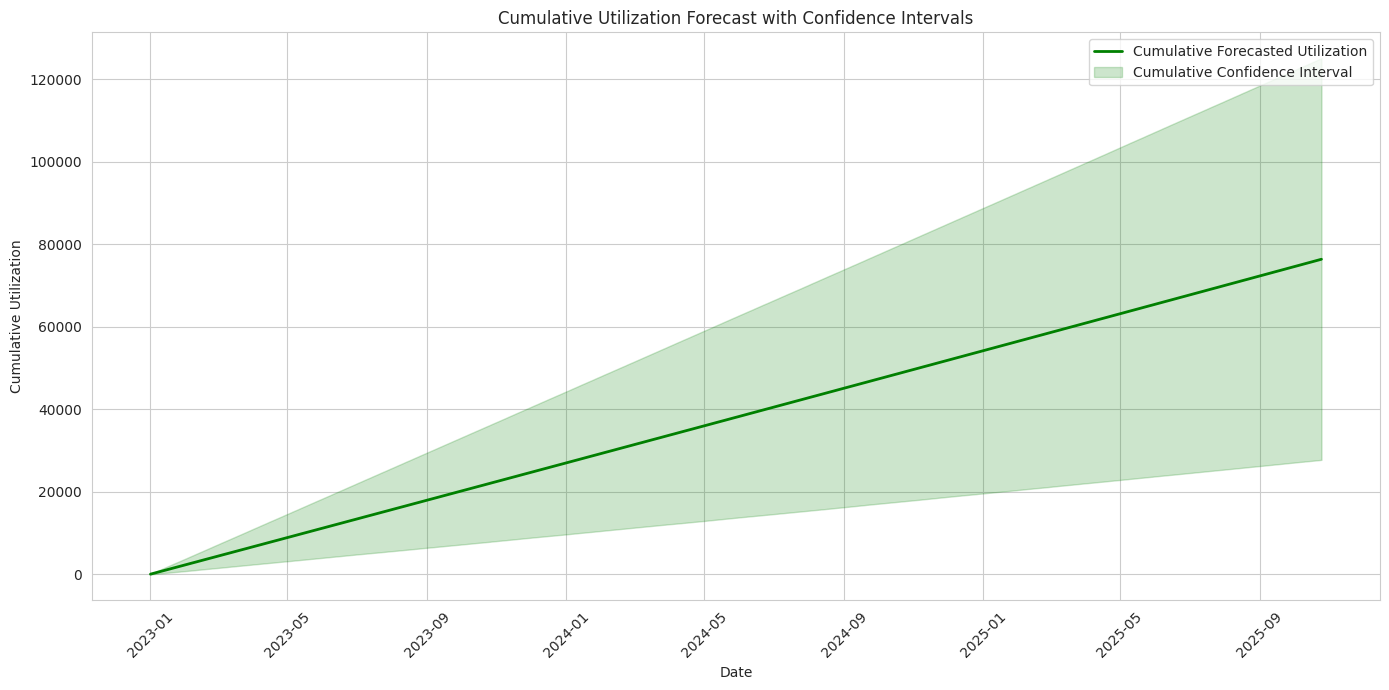

In [22]:
# Calculate cumulative utilization
forecast['cumulative_yhat'] = forecast['yhat'].cumsum()
forecast['cumulative_yhat_lower'] = forecast['yhat_lower'].cumsum()
forecast['cumulative_yhat_upper'] = forecast['yhat_upper'].cumsum()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the cumulative forecasted values
ax.plot(forecast['ds'], forecast['cumulative_yhat'], label='Cumulative Forecasted Utilization', color='green', linewidth=2)

# Plot the confidence intervals for cumulative values
ax.fill_between(forecast['ds'], forecast['cumulative_yhat_lower'], forecast['cumulative_yhat_upper'], color='green', alpha=0.2, label='Cumulative Confidence Interval')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Utilization')
ax.set_title('Cumulative Utilization Forecast with Confidence Intervals')
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# XGBOOST 

In [23]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5)

# Grid Search with Cross Validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Best model from Grid Search
best_xgb_model = grid_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nROC AUC Score: {roc_auc_xgb}")

cv_scores_xgb = cross_val_score(best_xgb_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores_xgb}")
print(f"Mean CV ROC AUC score: {cv_scores_xgb.mean()}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Confusion Matrix:
[[100  18]
 [ 57 489]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       118
           1       0.96      0.90      0.93       546

    accuracy                           0.89       664
   macro avg       0.80      0.87      0.83       664
weighted avg       0.91      0.89      0.89       664


ROC AUC Score: 0.9555472775811759

Cross-validation ROC AUC scores: [0.96015798 0.96277716 0.96432927 0.98054167 0.967375  ]
Mean CV ROC AUC score: 0.9670362158167036


In [24]:
# Visualizations
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

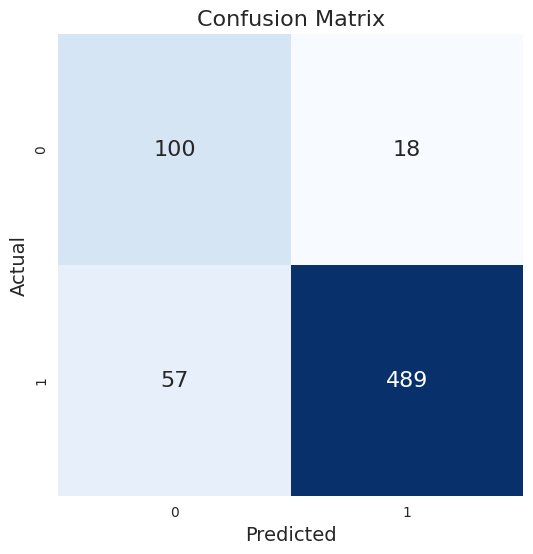

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       118
           1       0.96      0.90      0.93       546

    accuracy                           0.89       664
   macro avg       0.80      0.87      0.83       664
weighted avg       0.91      0.89      0.89       664



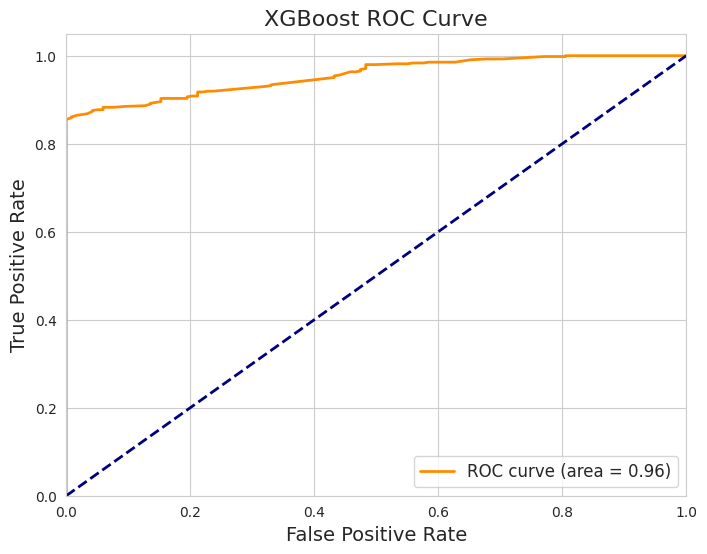

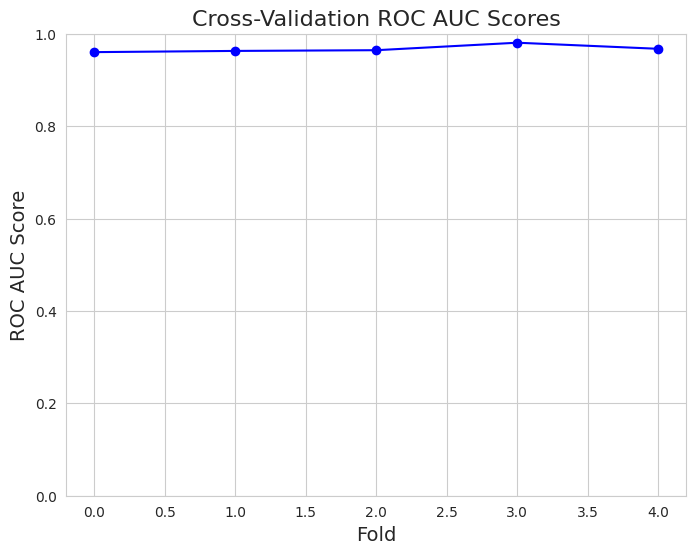

In [25]:
plot_confusion_matrix(y_test, y_pred_xgb)
plot_classification_report(y_test, y_pred_xgb)
plot_roc_curve(y_test, y_prob_xgb, title='XGBoost ROC Curve')
plot_cv_roc_auc_scores(cv_scores_xgb)


# CATBOOST

In [26]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Define the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Define the parameter grid for GridSearchCV
catboost_param_grid = {
    'iterations': [50, 100, 200],
    'depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5)

# Grid Search with Cross Validation
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_catboost.fit(X_train, y_train)

# Best model from Grid Search
best_catboost_model = grid_search_catboost.best_estimator_

# Predict on the test set
y_pred_catboost = best_catboost_model.predict(X_test)
y_prob_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_catboost))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

roc_auc_catboost = roc_auc_score(y_test, y_prob_catboost)
print(f"\nROC AUC Score: {roc_auc_catboost}")

cv_scores_catboost = cross_val_score(best_catboost_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores_catboost}")
print(f"Mean CV ROC AUC score: {cv_scores_catboost.mean()}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Confusion Matrix:
[[ 97  21]
 [ 48 498]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       118
           1       0.96      0.91      0.94       546

    accuracy                           0.90       664
   macro avg       0.81      0.87      0.84       664
weighted avg       0.91      0.90      0.90       664


ROC AUC Score: 0.9585894331657044

Cross-validation ROC AUC scores: [0.96251386 0.9620704  0.96779379 0.97977778 0.96958333]
Mean CV ROC AUC score: 0.9683478319783199


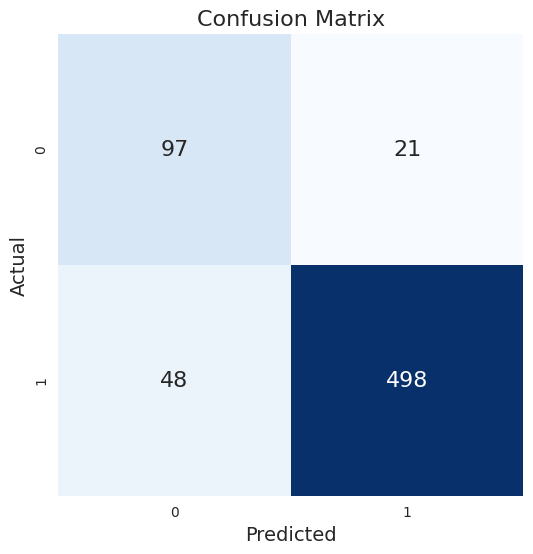

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       118
           1       0.96      0.91      0.94       546

    accuracy                           0.90       664
   macro avg       0.81      0.87      0.84       664
weighted avg       0.91      0.90      0.90       664



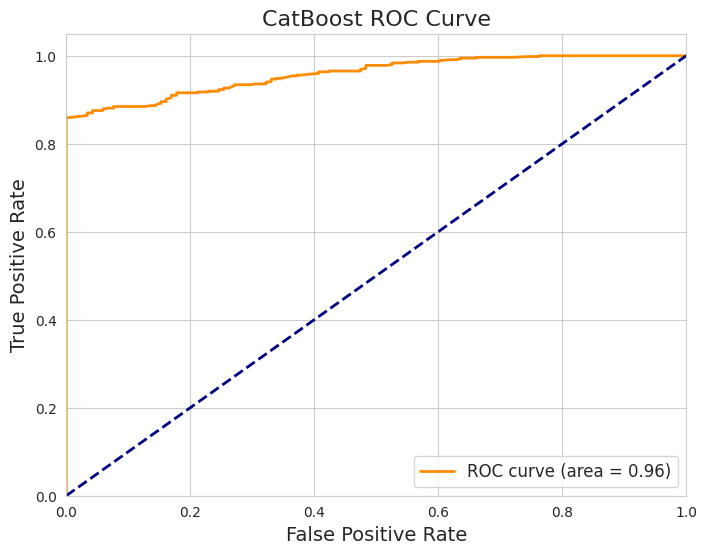

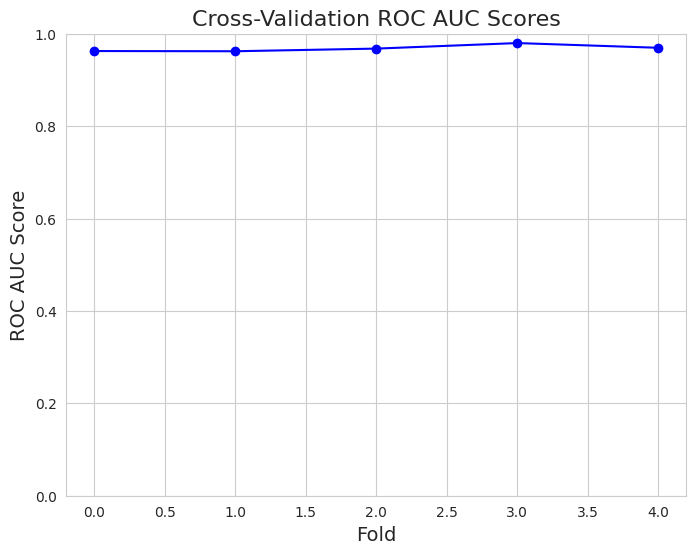

In [27]:
# Visualizations
plot_confusion_matrix(y_test, y_pred_catboost)
plot_classification_report(y_test, y_pred_catboost)
plot_roc_curve(y_test, y_prob_catboost, title='CatBoost ROC Curve')
plot_cv_roc_auc_scores(cv_scores_catboost)